In [1]:
import pandas as pd
import pickle as pk

import networkx as nx
import numpy as np
from scipy import stats
from itertools import permutations
import event_functions as ev

from wordcloud import WordCloud
import json

import matplotlib
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
plt.style.use('seaborn-v0_8-white')

In [2]:
topics_names=['Assault on Vice President','Vice President','Diplomatic conflict','Former Economy Minister','Economy Minister',
              'Gas Pipeline','Social Leader','Domestic politics','Vice President Trials','Dollar','Supreme Court','Government',
              'Inflation','Strikes','Fuel Shortage','Libertarian Party','Subsidy Segmentation',
               'Opposition','International affairs','Social Assistance']

topics=20
topics_labels=['T{}'.format(i) for i in range(1,topics+1)]
dict_titles={k:v for k,v in zip(topics_names,topics_labels)}

#provinces to work with:
provincias2analyze= ['Buenos Aires', 'Cordoba','Tucuman','Mendoza','Santa Fe','Santiago del estero']
provincias2analyze_labels=['Buenos Aires', 'Córdoba','Tucumán','Mendoza','Santa Fe','Santiago del Estero']

provincias_labels={k:v for k,v in zip(provincias2analyze,provincias2analyze_labels)}

#Load the time series and create their respective distributions 
dfs=[]
dist_topicos={}
for interest_top in topics_labels:
    #Series continuas
    n='topic_series_{}.txt'.format(interest_top)
    dfcont=pd.read_csv(r'./Data/'+n)
    dfs.append(dfcont)

    series=[]
    for prov in provincias2analyze:
        serie_prov=dfcont[prov].to_numpy()          
        series.extend(serie_prov)            
    distsel=series
    dist_topicos[interest_top]=distsel

#Check the wordclouds
with open(r'./Data/series_H20.npy', 'rb') as f:
    H=np.load(f,allow_pickle=True)    
    
# Opening index term dictionary
f = open(r'./Data/ind2term.json')
ind2term = json.load(f)

# indices to select
iu1 = np.triu_indices(len(provincias2analyze), 1)
indxi=iu1[0]
indxj=iu1[1]

#Lag to work with
Lag=3

#Style
L_prov=len(provincias2analyze)
fontsize_big=30 #titles
fontsize_normal=25 #labels
fontsize_small=20 #ticks
fontsize_xsmall=18
fontsize_xxsmall=15

# Time serie inspection

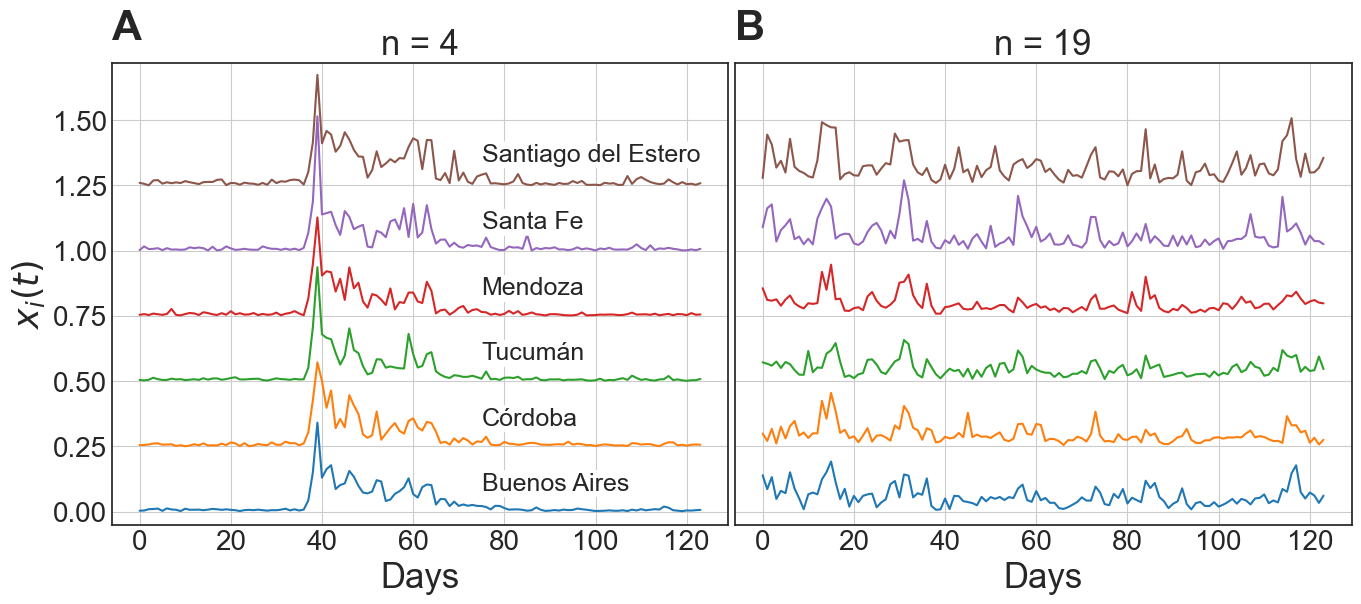

In [3]:
#selecting the topics
int_top1='Former Economy Minister'
int_top2='International affairs'

fig, axs = plt.subplots(1,2,figsize=(16,6),sharey=True)
ax1,ax2=axs
top_ind1=topics_names.index(int_top1)
dfsel=dfs[top_ind1]
yticks_ax1=[]
ysticks=[]
#plot the topic for each province
for i,p1 in enumerate(provincias2analyze):
    serie=dfsel[p1]
    y=serie+(i*0.25)
    yticks_ax1.append(np.mean(y))
    ax1.plot(y,label=p1)
    
top_ind2=topics_names.index(int_top2)
dfsel=dfs[top_ind2]
for i,p1 in enumerate(provincias2analyze):
    serie=dfsel[p1]
    y=serie+(i*0.25)
    ax2.plot(y,label=p1)

#Style 
ax1.grid(True)
ax1.set_title('n = {}'.format(dict_titles[int_top1].strip('T')),fontsize=fontsize_normal)
ax1.tick_params(axis='y', which='major', labelsize=fontsize_small)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylim([-0.05,1.72])
ax1.set_xlabel('Days',fontsize=25)

ax2.set_title('n = {}'.format(dict_titles[int_top2].strip('T')),fontsize=fontsize_normal)
ax2.grid(True)
ax2.set_xlabel('Days',fontsize=25)
ax1.set_ylabel('$x_{i}(t)$',fontsize=25)
ax1.tick_params(axis='x', which='major', labelsize=fontsize_small)
ax2.tick_params(axis='x', which='major', labelsize=fontsize_small)

ax1.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)
ax2.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax2.transAxes)

# Add the province name in the graph
for y_pos,txt in zip(yticks_ax1,provincias2analyze_labels):
    ax1.text(75, y_pos+0.05, txt, fontsize=fontsize_xsmall, ha='left',
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.05'))

plt.subplots_adjust(wspace=0.01)
plt.show()

# Example of event detection

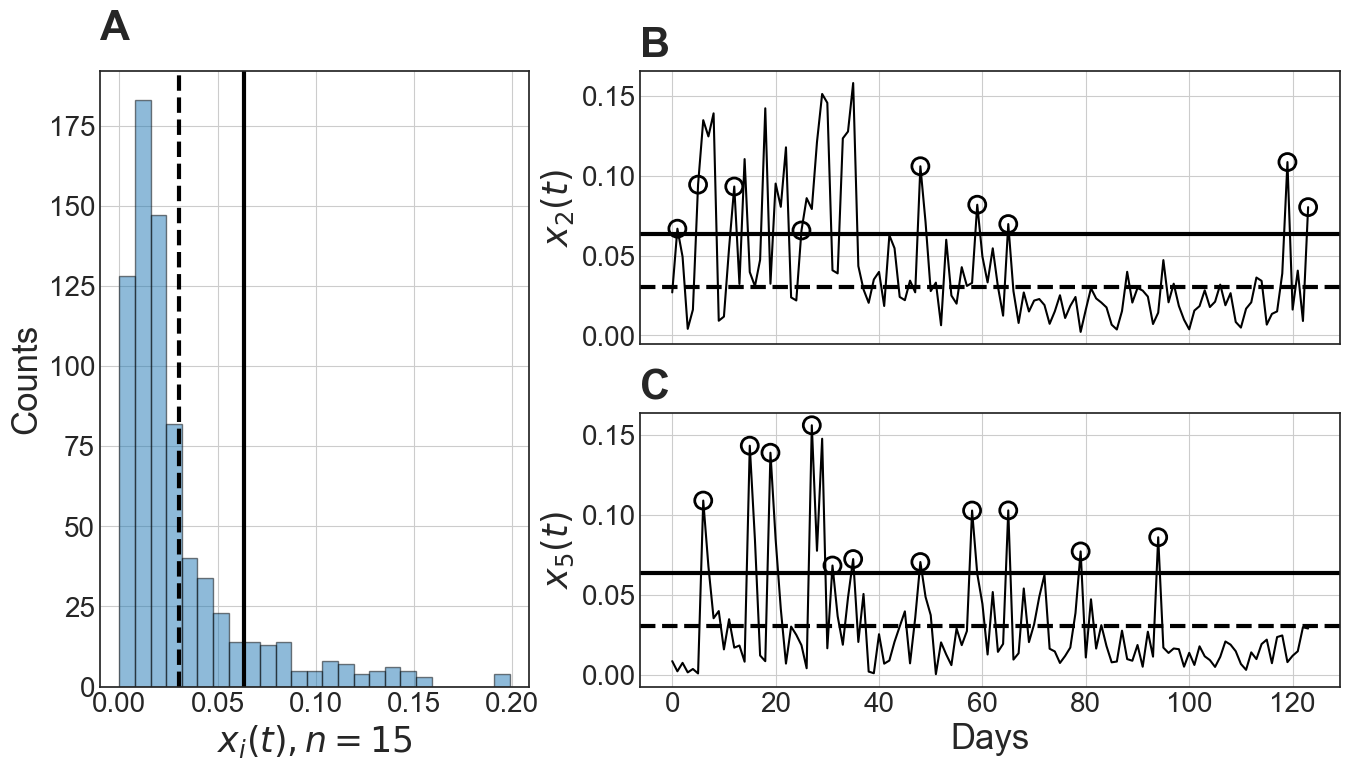

In [4]:
#selecting the topic and the provinces
int_top='Fuel Shortage'
j1,j2 ='Cordoba','Santa Fe'

dfsel=dfs[topics_names.index(int_top)]
#def thresholds
distsel=dist_topicos[dict_titles[int_top]]
th0=np.mean(distsel)
th1=th0+np.std(distsel)


fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 5)
ax0 = fig.add_subplot(gs[0,2:5])
ax1 = fig.add_subplot(gs[1,2:5])
ax = fig.add_subplot(gs[:,0:2])

#plot the histogram
ax.hist(distsel,bins=25,alpha=0.5,edgecolor='black')
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
ax.set_ylabel('Counts',fontsize=fontsize_normal)


#plot the series with the events
y1=dfsel[j1].copy()
y2=dfsel[j2].copy()

x1=range(len(dfsel[j1]))
p1,=ax0.plot(y1,color='k',label=j1)
p2,=ax1.plot(y2,color='k',label=j2)

ev_array1=ev.event_transformer(y1,th1,th0) #serie binaria de eventos
indev1=np.nonzero(ev_array1) #posiciones de eventos
noe_c1=indev1[0].shape[0] #cantidad de eventos

ev_array2=ev.event_transformer(y2,th1,th0)
indev2=np.nonzero(ev_array2)
noe_c2=indev2[0].shape[0]

y_eventos1=dfsel[j1].to_numpy()[indev1] #posiciones en el eje y de los eventos
ax0.scatter(indev1,y_eventos1,s=150,facecolors='none', edgecolors='k',linewidth=2,zorder=3)

y_eventos2=dfsel[j2].to_numpy()[indev2]
ax1.scatter(indev2,y_eventos2,s=150,facecolors='none', edgecolors='k',linewidth=2,zorder=3)

#Style
ax0.axhline(th1,c='k',ls='-',lw=3)
ax0.axhline(th0,c='k',ls='--',lw=3)
ax1.axhline(th1,c='k',ls='-',lw=3)
ax1.axhline(th0,c='k',ls='--',lw=3)
ax.axvline(th1,c='k',ls='-',label='$\mu + \sigma$',lw=3)
ax.axvline(th0,c='k',ls='--',label='$\mu$',lw=3)

ax0.grid(True)
ax1.grid(True)

int_j1=provincias2analyze.index(j1)+1
int_j2=provincias2analyze.index(j2)+1
st1='x_{}'.format(int_j1)+'(t)'
ax0.set_ylabel(r'${}$'.format(st1),fontsize=fontsize_normal)
st2='x_{}'.format(int_j2)+'(t)'
ax1.set_ylabel(r'${}$'.format(st2),fontsize=fontsize_normal)

N=dict_titles[int_top].strip('T')
st=r'x_{i}(t),'+' n={}'.format(N)
ax.set_xlabel(r'${}$'.format(st),fontsize=fontsize_normal)

ax1.set_xlabel('Days',fontsize=25)
ax0.set_xticklabels([])
ax0.tick_params(axis='y', which='major', labelsize=fontsize_small)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_small)

ax.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax.transAxes)
ax0.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax0.transAxes)
ax1.text(x=0, y=1.05, s="C", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)

plt.subplots_adjust(wspace=0.7,hspace=0.25)
plt.show()

# Example of coincidence method

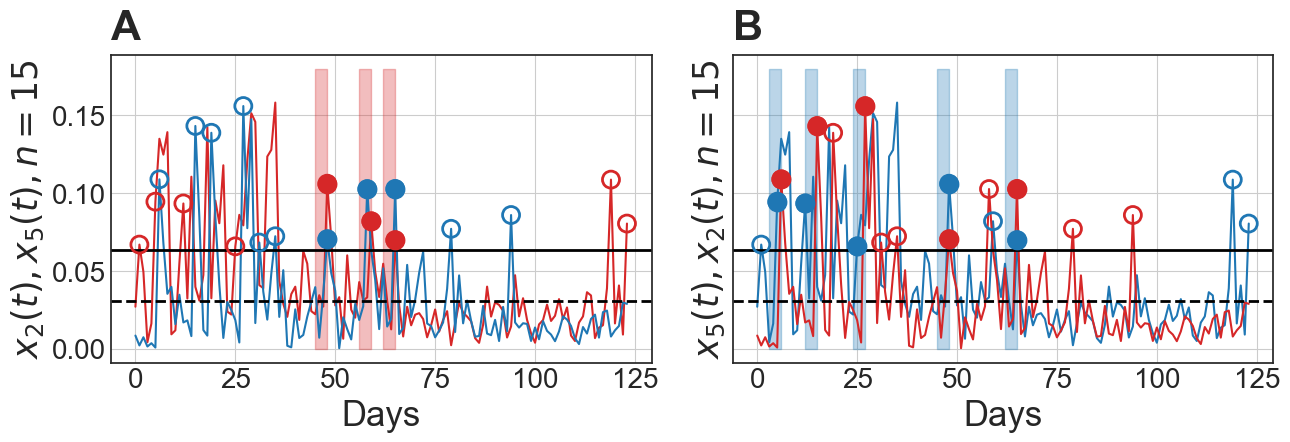

In [5]:
fig, axs = plt.subplots(1,2,figsize=(15,4),sharey=True)
ax0=axs[0]
ax1=axs[1]

#plot the two time series with their coincideces
y1=dfsel[j1].copy()
y2=dfsel[j2].copy()
x1=range(len(dfsel[j1]))
p1,=ax0.plot(y1,color='tab:red',label=j1)
p2,=ax0.plot(y2,color='tab:blue',label=j2)

p1,=ax1.plot(y1,color='tab:blue',label=j1)
p2,=ax1.plot(y2,color='tab:red',label=j2)

#plot the events
ev_array1=ev.event_transformer(y1,th1,th0)
indev1=np.nonzero(ev_array1)
noe_c1=indev1[0].shape[0]

eventos1=dfsel[j1].to_numpy()[indev1]
ax0.scatter(indev1,eventos1,s=150,facecolors='none', edgecolors='tab:red',linewidth=2,zorder=3)
ax1.scatter(indev1,eventos1,s=150,facecolors='none', edgecolors='tab:blue',linewidth=2,zorder=3)

ev_array2=ev.event_transformer(y2,th1,th0)
indev2=np.nonzero(ev_array2)
noe_c2=indev2[0].shape[0]

eventos2=dfsel[j2].to_numpy()[indev2]
ax0.scatter(indev2,eventos2,s=150,facecolors='none', edgecolors='tab:blue',linewidth=2,zorder=3)
ax1.scatter(indev2,eventos2,s=150,facecolors='none', edgecolors='tab:red',linewidth=2,zorder=3)

#search for coincidences and paint them
indx_a,c_a=ev.f_coin(ev_array1,ev_array2,lag=Lag)
indx_b,c_b=ev.f_coin(ev_array2,ev_array1,lag=Lag)

coincidencias_az=[]
for ev_az in indev2[0]:
    for ev_r in indev1[0]:
        dif= ev_az - ev_r
        if 0<= dif <= Lag:
            #si appendeo ev_az veo los eventos azules sobre rojo
            #si appendeo ev_r veo los eventos en rojo que ven los azules
            coincidencias_az.append(ev_r)
        else:
            coincidencias_az.append('nan')

coincidencias_az=np.asarray(coincidencias_az)
coin_az=coincidencias_az[coincidencias_az.astype(str)  != 'nan']
indx2paint_az=[int(x) for x in coin_az]

evb=dfsel[j1].to_numpy()[indx2paint_az]
ax1.scatter(indx2paint_az,evb,s=150, color='tab:blue',linewidth=2,zorder=3)

coincidencias_r=[]
for ev_r in indev1[0]:
    for ev_az in indev2[0]:
        dif= ev_r - ev_az
        if 0<= dif <= Lag:
            coincidencias_r.append(ev_az)
        else:
            coincidencias_r.append('nan')

coincidencias_r=np.asarray(coincidencias_r)
coin_r=coincidencias_r[coincidencias_r.astype(str) != 'nan']
indx2paint_r=[int(x) for x in coin_r]
evb=dfsel[j2].to_numpy()[indx2paint_r]
ax0.scatter(indx2paint_r,evb,s=150, color='tab:blue',linewidth=2,zorder=3)        


eva=dfsel[j2].to_numpy()[indx_a]
ax1.scatter(indx_a,eva,s=150, color='tab:red',linewidth=2,zorder=3)

evb=dfsel[j1].to_numpy()[indx_b]
ax0.scatter(indx_b,evb,s=150, color='tab:red',linewidth=2,zorder=3)


#Style & paint the time window
yticks = plt.yticks()[0]
ys=np.linspace(0,max(yticks))
for ix in indx_a:
    ax1.fill_betweenx(ys, ix-Lag, ix, color='tab:blue', alpha=0.3)
for ix in indx_b:
    ax0.fill_betweenx(ys, ix-Lag, ix, color='tab:red', alpha=0.3)


ax0.axhline(th1,c='k',ls='-',lw=2)
ax0.axhline(th0,c='k',ls='--',lw=2)
ax1.axhline(th1,c='k',ls='-',lw=2)
ax1.axhline(th0,c='k',ls='--',lw=2)


ax0.grid(True)
ax1.grid(True)

int_j1=provincias2analyze.index(j1)+1
int_j2=provincias2analyze.index(j2)+1
st1='x_{}'.format(int_j1)+'(t)'+', ' + 'x_{}'.format(int_j2)+'(t),'+' n={}'.format(N)
ax0.set_ylabel(r'${}$'.format(st1),fontsize=fontsize_normal)
st2='x_{}'.format(int_j2)+'(t)'+', ' + 'x_{}'.format(int_j1)+'(t),' +' n={}'.format(N)
ax1.set_ylabel(r'${}$'.format(st2),fontsize=fontsize_normal)

ax0.set_xlabel('Days',fontsize=fontsize_normal)
ax1.set_xlabel('Days',fontsize=fontsize_normal)

ax0.tick_params(axis='both', which='major', labelsize=fontsize_small)
ax1.tick_params(axis='both', which='major', labelsize=fontsize_small)

ax0.text(x=0, y=1.05, s="A", fontsize=fontsize_big,fontweight='bold', transform=ax0.transAxes)
ax1.text(x=0, y=1.05, s="B", fontsize=fontsize_big,fontweight='bold', transform=ax1.transAxes)

plt.subplots_adjust(wspace=0.15)
plt.show()

# Creation of $Q_{s}$ & $Q_{a}$ matrices

In [6]:
#Create Qs & Qa matrices
matrices_topicos={}
for t,interest_top in enumerate(topics_names):
    dfcont=dfs[t]    

    #def thresholds
    distsel=dist_topicos[dict_titles[int_top]]
    th0=np.mean(distsel)
    th1=th0+np.std(distsel)

    umbrales=(th0,th1)    
    matrices_c_umbrales={}
    QS=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    QA=np.zeros((len(provincias2analyze),len(provincias2analyze)))
    for i,p1 in enumerate(provincias2analyze):
        #search for events and coincidences
        c1=ev.event_transformer(dfcont[p1],th1,th0)
        noe_c1=np.nonzero(c1)[0].shape[0]
        for j,p2 in enumerate(provincias2analyze):
            c2=ev.event_transformer(dfcont[p2],th1,th0)        
            noe_c2=np.nonzero(c2)[0].shape[0]
            _,c_a=ev.f_coin(c1,c2,lag=Lag)
            _,c_b=ev.f_coin(c2,c1,lag=Lag)
            eventos_totales=(noe_c1+noe_c2)
            #calculate the elements of the matrices
            if eventos_totales != 0:
                s= (c_b+ c_a)/eventos_totales
                a= (c_b - c_a)/eventos_totales
            else:
                s=0
                a=0
            QS[i,j]=s
            QA[i,j]=a            
    QS=2*QS
    QA=2*QA
    np.fill_diagonal(QS,0)
    np.fill_diagonal(QA,0)
    
    matrices_topicos[interest_top]=(QS,QA,umbrales)

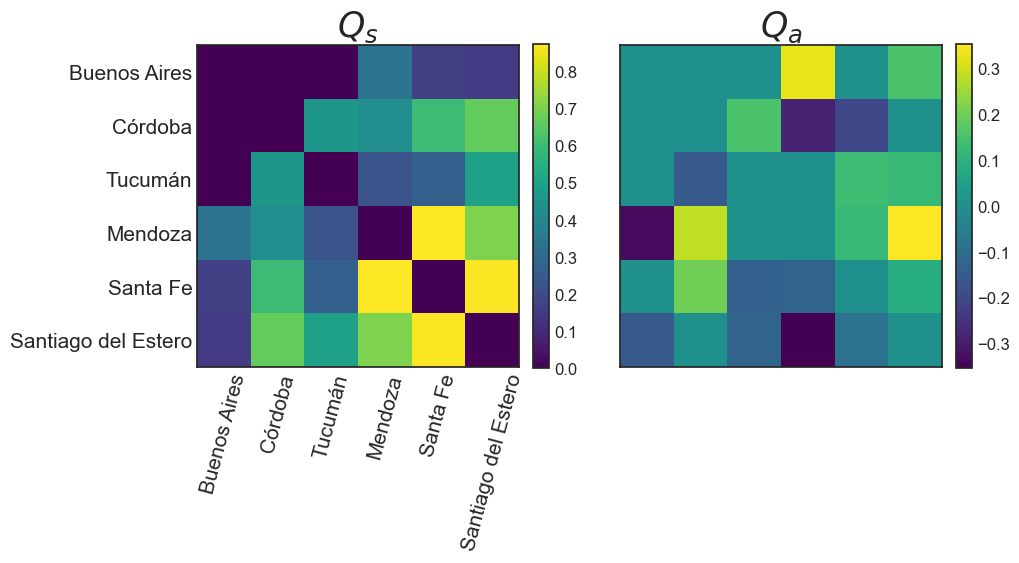

In [7]:
#select the topic to show matrices Qs and Qa
int_top='Fuel Shortage'
QS,QA,_=matrices_topicos[int_top]

fig, axes = plt.subplots(1, 2, figsize=(10, 5),sharey=True)

ax0,ax1=axes.flatten()

cax1 = ax0.imshow(QS, cmap='viridis')
cbar1 =fig.colorbar(cax1, ax=ax0, fraction=0.046, pad=0.04)
cbar1.ax.tick_params(labelsize=12)
ax0.set_title('$Q_{s}$',fontsize=fontsize_normal)

cax2 = ax1.imshow(QA, cmap='viridis')
cbar2 =fig.colorbar(cax2, ax=ax1, fraction=0.046, pad=0.04)
cbar2.ax.tick_params(labelsize=12)
ax1.set_title('$Q_{a}$',fontsize=fontsize_normal)


# Setting the ticks
ax0.set_yticks(np.arange(len(provincias2analyze_labels)))
ax0.set_yticklabels(provincias2analyze_labels,fontsize=fontsize_xxsmall)
ax0.set_xticks(np.arange(len(provincias2analyze_labels)))
ax0.set_xticklabels(provincias2analyze_labels, rotation=75,fontsize=fontsize_xxsmall)

# Remove ticks right panel
ax1.set_xticks([])

plt.show()

# Wordclouds

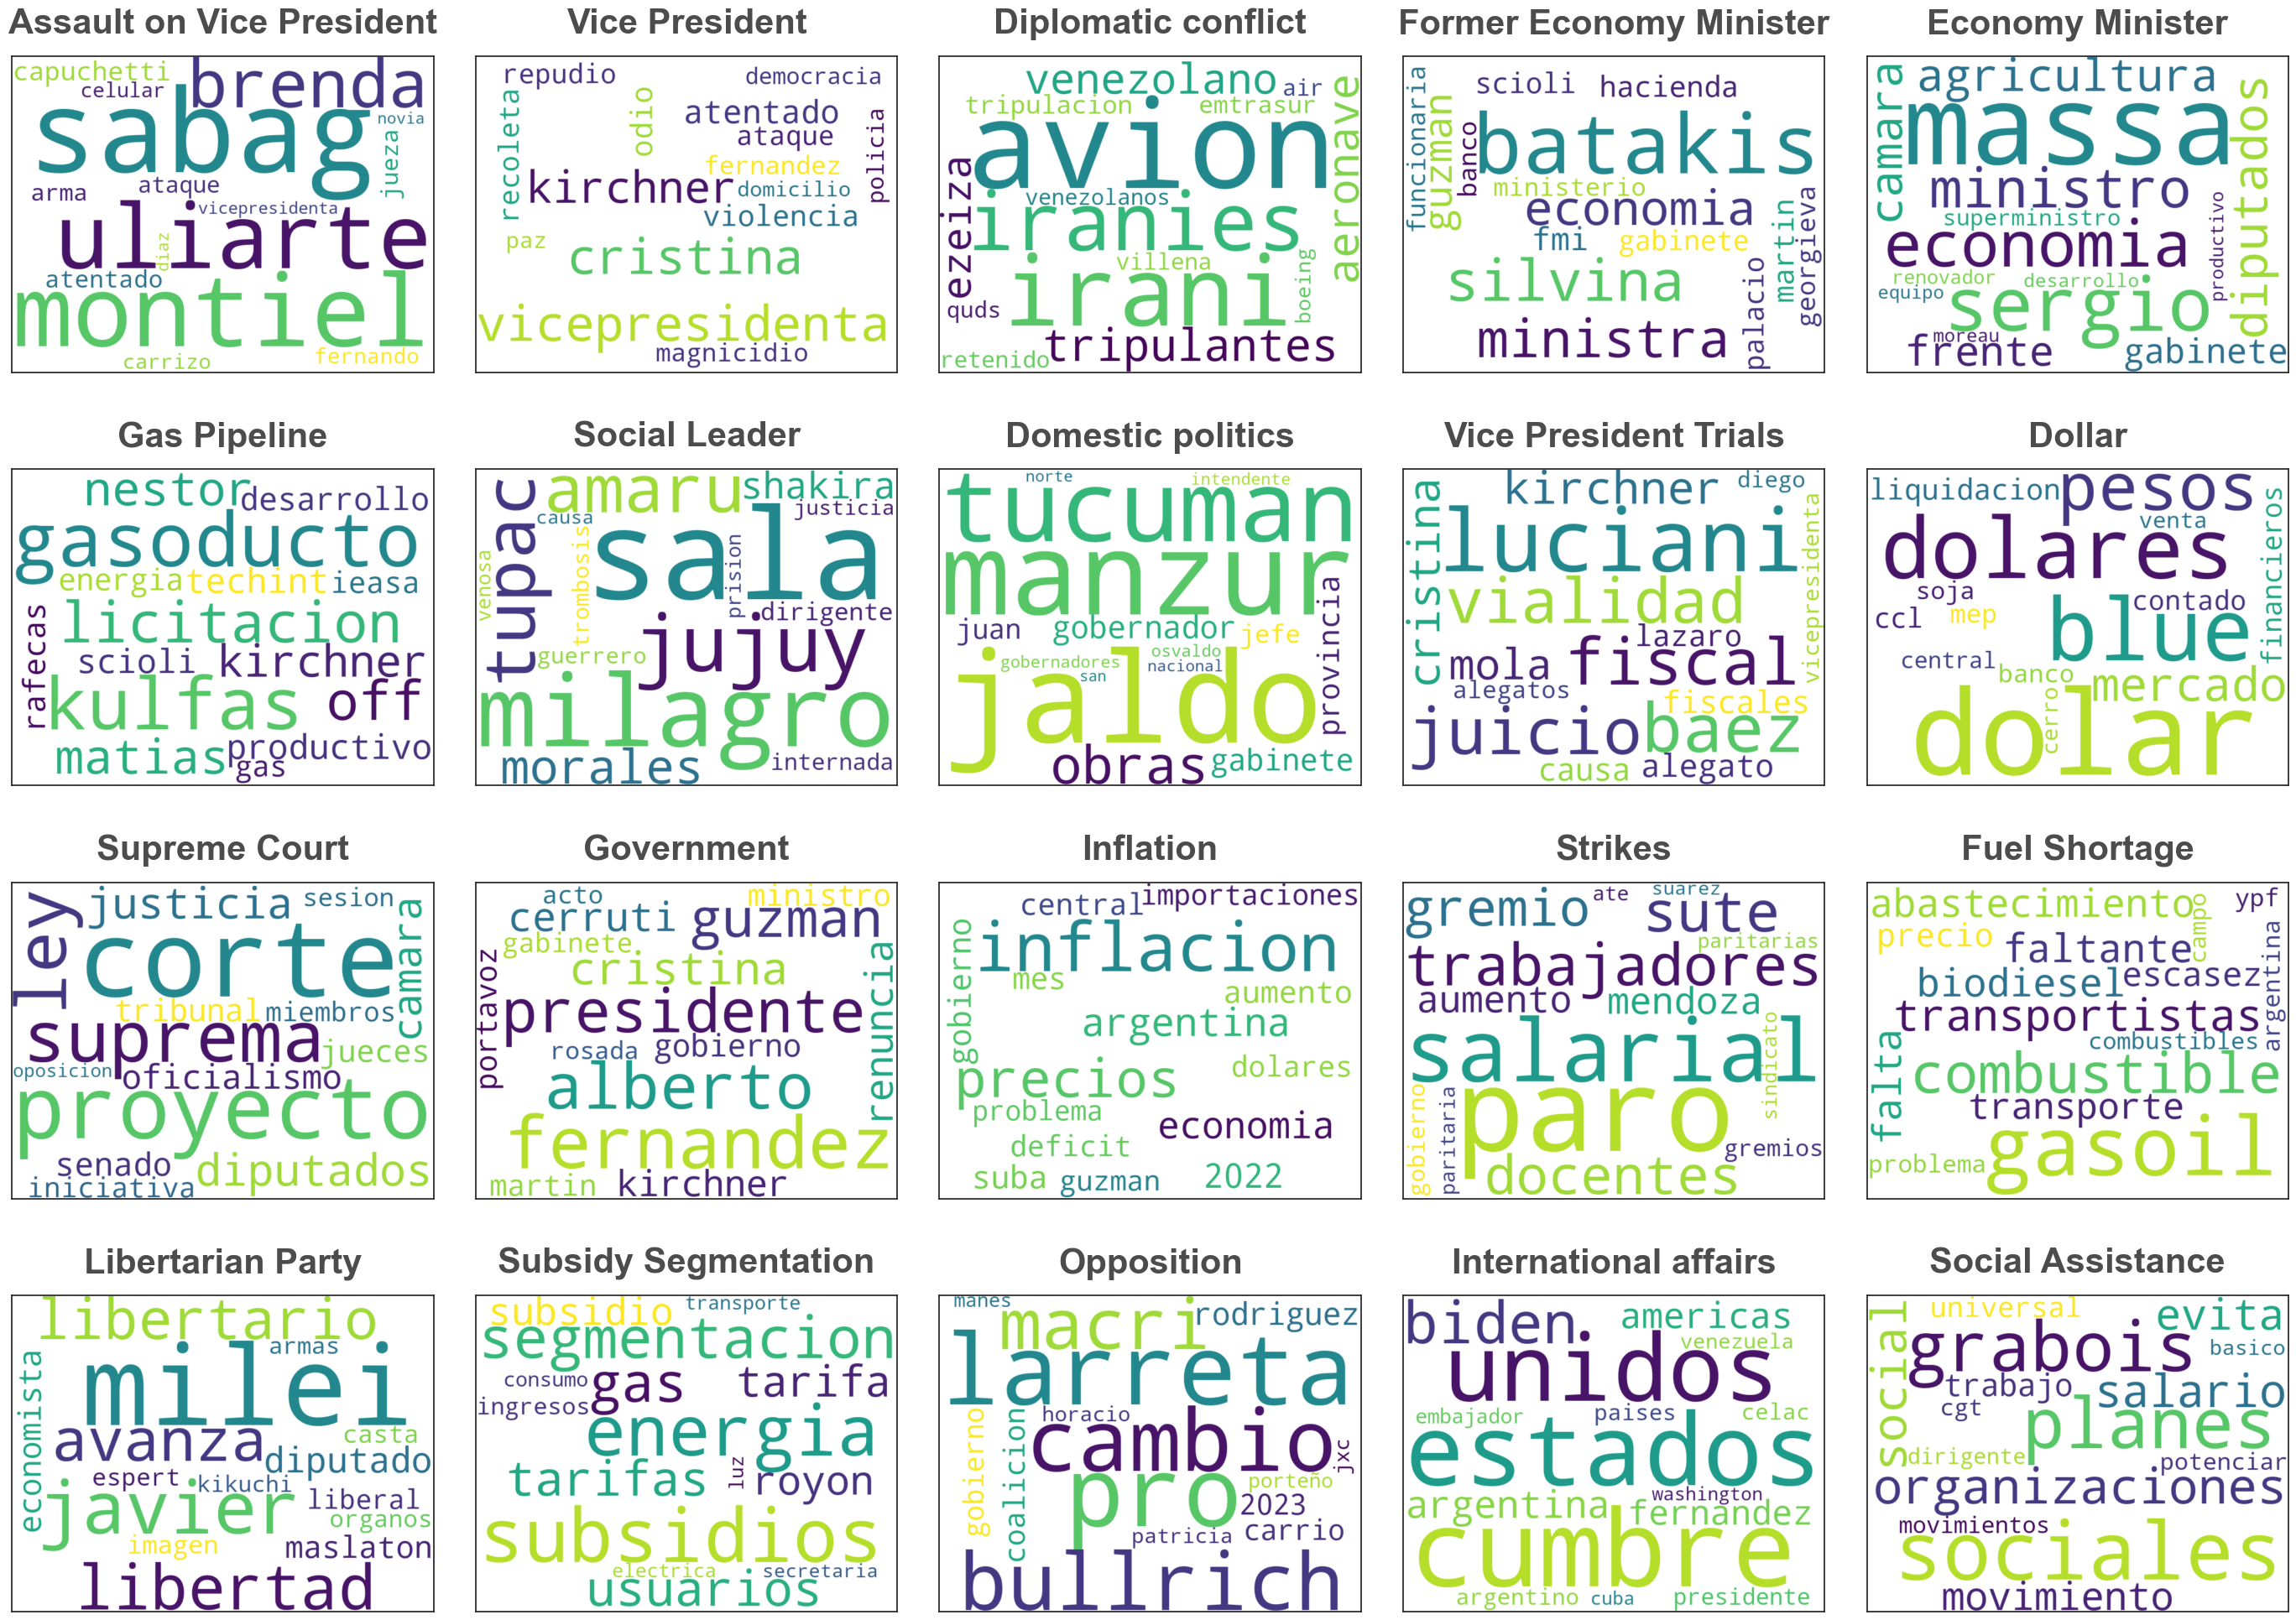

In [8]:
#number of keywords to display
nkeywords=15

#indices of the topics located in the H matrix
indexes_H={'Government':0,'Vice President Trials':1,'Opposition':2,'Assault on Vice President':3,'Diplomatic conflict':4,
            'Inflation':5,'Dollar':6,'Economy Minister':7,'Former Economy Minister':8,'Social Assistance':9,
           'Supreme Court':10,'International affairs':11,'Gas Pipeline':12,'Libertarian Party':13,'Social Leader':14,
            'Fuel Shortage':15,'Subsidy Segmentation':16,'Strikes':17,'Vice President':18,'Domestic politics':19}

#Style
wordcloud_dict={'background_color':'white',
    'width':800,
    'height':600,
    'max_words':200,  # Ajusta la cantidad de palabras que deseas mostrar
    'colormap':'viridis_r',  # Puedes cambiar el esquema de colores
    'contour_color':'black',  # Color del contorno de las palabras
    }

    
fig, axes = plt.subplots(4, 5, figsize=(35, 25))
axinx=[]
axiny=[]
for i in range(4):
    for j in range(5):
        axinx.append(i)
        axiny.append(j)

for name,xind,yind in zip(topics_names,axinx,axiny):
    ax=axes[xind,yind]
    topic_inx=indexes_H[name]
    topic_keywords_index = sorted(range(H.shape[1]), reverse=True, key = lambda x: H[topic_inx][x])[:nkeywords]
    
    palabrasimpo={}
    for tk in topic_keywords_index:
        palabrasimpo[ind2term['{}'.format(tk)]]=H[topic_inx][tk]

    wordcloud = WordCloud(**wordcloud_dict,random_state=100).generate_from_frequencies(palabrasimpo)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(name,color='k',fontsize=fontsize_big,fontweight='bold',y=1.05,alpha=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()